In [14]:
import cv2
import matplotlib.pyplot as plt
import time
import numpy as np

In [15]:
image = cv2.imread('uncropped/new_light1.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

50 106 77
25 88 77
28 93 71
52 108 79
Detection time: 0.013083696365356445


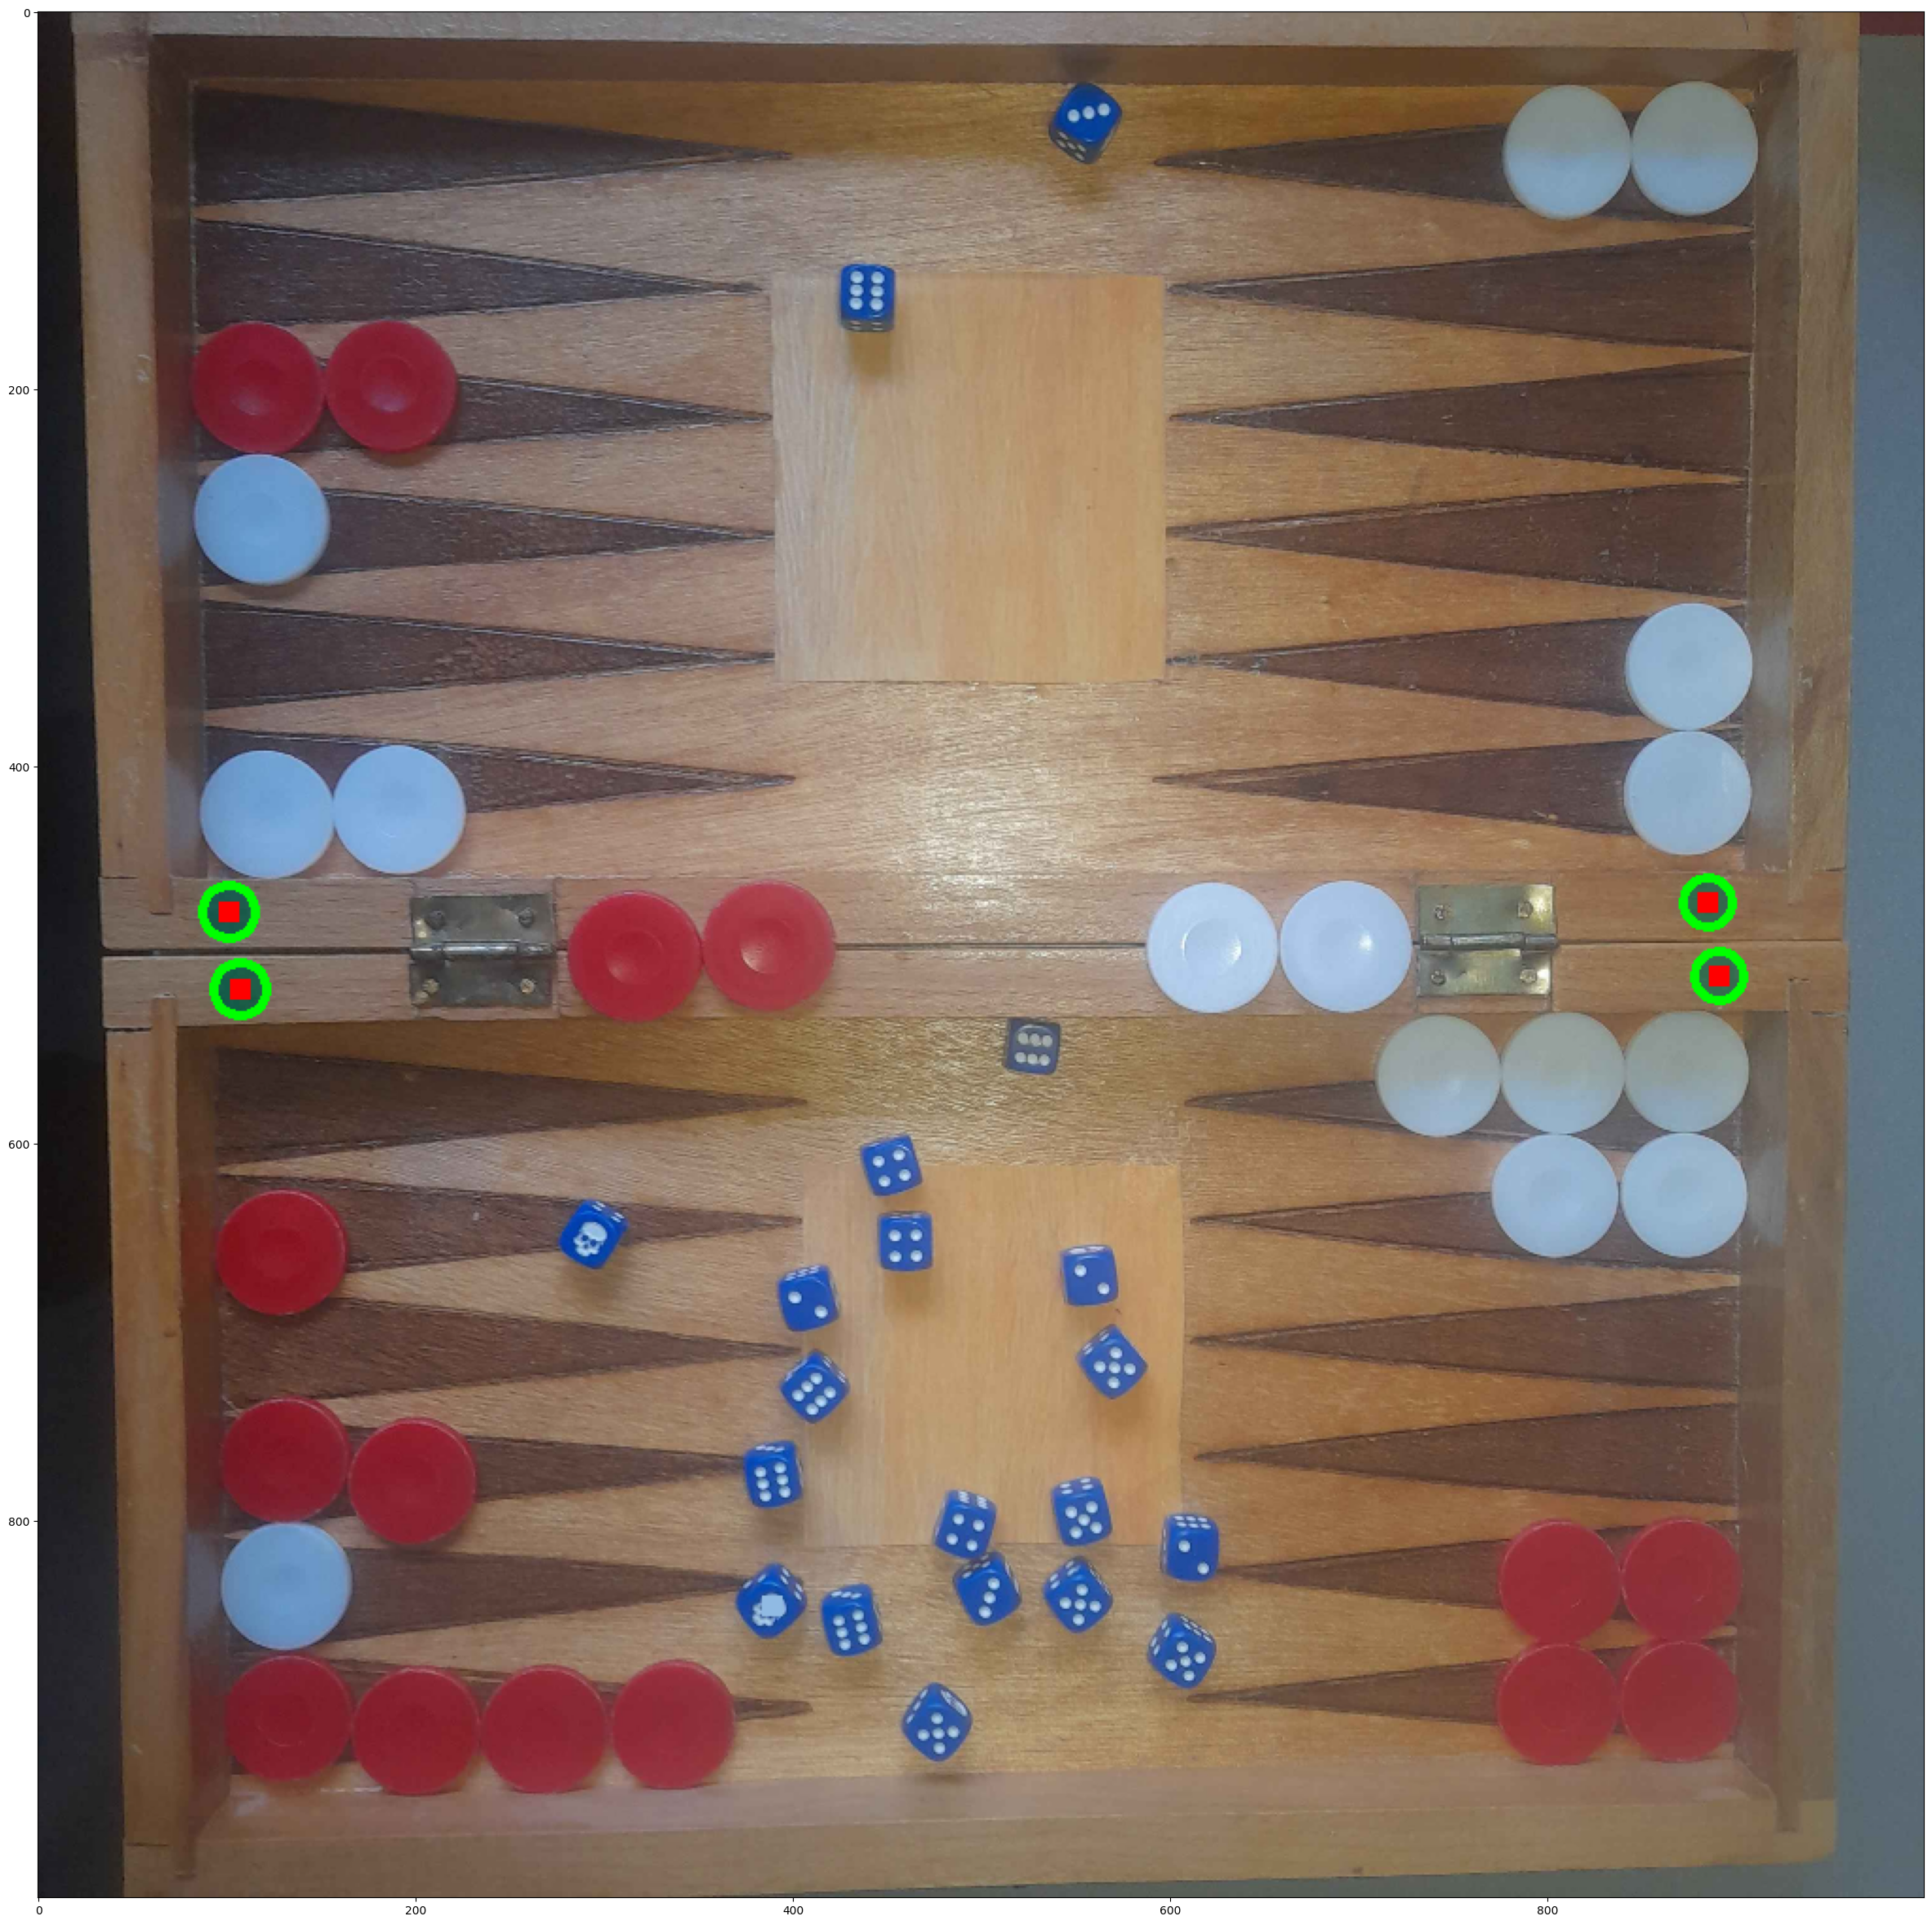

In [16]:

# Load the image
img = cv2.resize(image, (1000,1000))
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

start = time.time()

# Apply Gaussian Blur to reduce noise
# blurred = cv2.GaussianBlur(gray, (9, 9), 2)
blurred = cv2.GaussianBlur(gray, (5,5),0)
blurred = cv2.blur(blurred, (5,5))

# Detect circles using HoughCircles
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=5,
                           param1=50, param2=30, minRadius=1, maxRadius=20)

bar_indicators = []

# If circles are detected, draw them on the image
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        (R, G, B) = (int(img[y,x,0]),int(img[y,x,1]),int(img[y,x,2])) #!!! x and y places switched
        # print(R,G,B)
        # print(x,y)
        cv2.rectangle(img, (x - 5, y - 5), (x + 5, y + 5), (R, G, B), -1)  # Center
        if G - max(B,R) > 10 and G > 60 and G < 210:
            # print("^green")
            print(R,G,B)
            cv2.circle(img, (x, y), r, (0, 255, 0), 4)  # Circle
            cv2.rectangle(img, (x - 5, y - 5), (x + 5, y + 5), (255, 0, 0), -1)  # Center

            bar_indicators.append((x,y))

end = time.time()
print("Detection time:", end-start)

# Display the output
plt.figure(figsize=(30,30))
plt.imshow(img)
plt.show()

In [17]:
def orientation(p, q, r):
    """Return orientation of the triplet (p, q, r)."""
    return (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])

def on_segment(p, q, r):
    """Check if point r lies on segment pq."""
    return min(p[0], q[0]) <= r[0] <= max(p[0], q[0]) and min(p[1], q[1]) <= r[1] <= max(p[1], q[1])

def do_lines_intersect(A, B, C, D):
    """Return True if line segments AB and CD intersect."""
    o1 = orientation(A, B, C)
    o2 = orientation(A, B, D)
    o3 = orientation(C, D, A)
    o4 = orientation(C, D, B)

    # General case: Check if the segments straddle each other
    if o1 * o2 < 0 and o3 * o4 < 0:
        return True

    # Special cases: Check collinear cases where points lie on each other
    if o1 == 0 and on_segment(A, B, C):
        return True
    if o2 == 0 and on_segment(A, B, D):
        return True
    if o3 == 0 and on_segment(C, D, A):
        return True
    if o4 == 0 and on_segment(C, D, B):
        return True

    return False


[(885, 472), (101, 477), (107, 518), (891, 511)]
(0, 3) (1, 2)
[885, 101, 107, 891]
[472, 477, 518, 511]


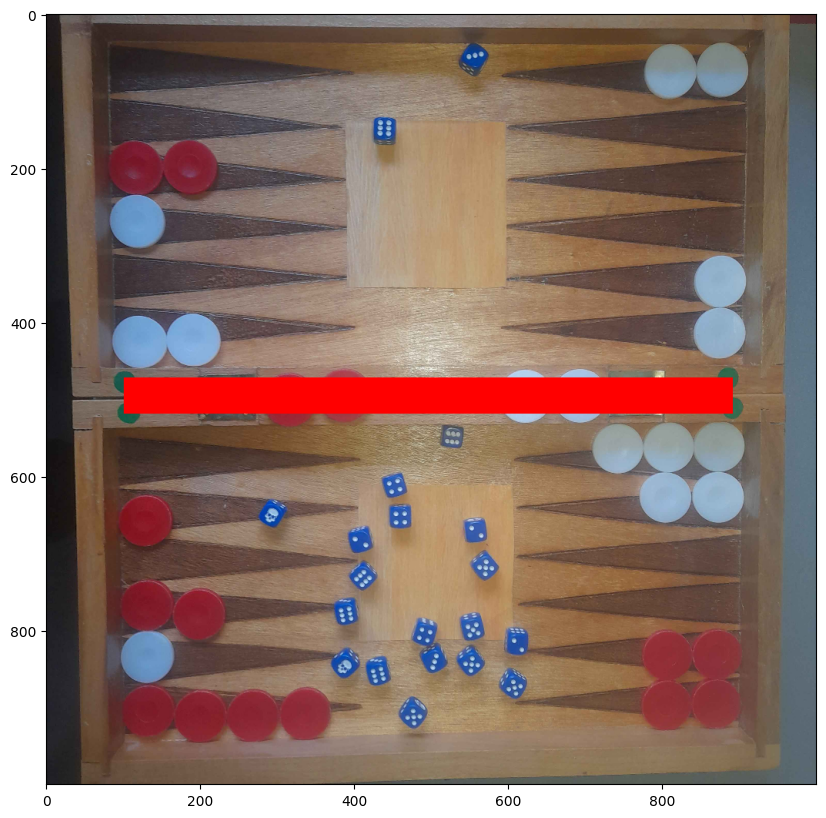

swapped


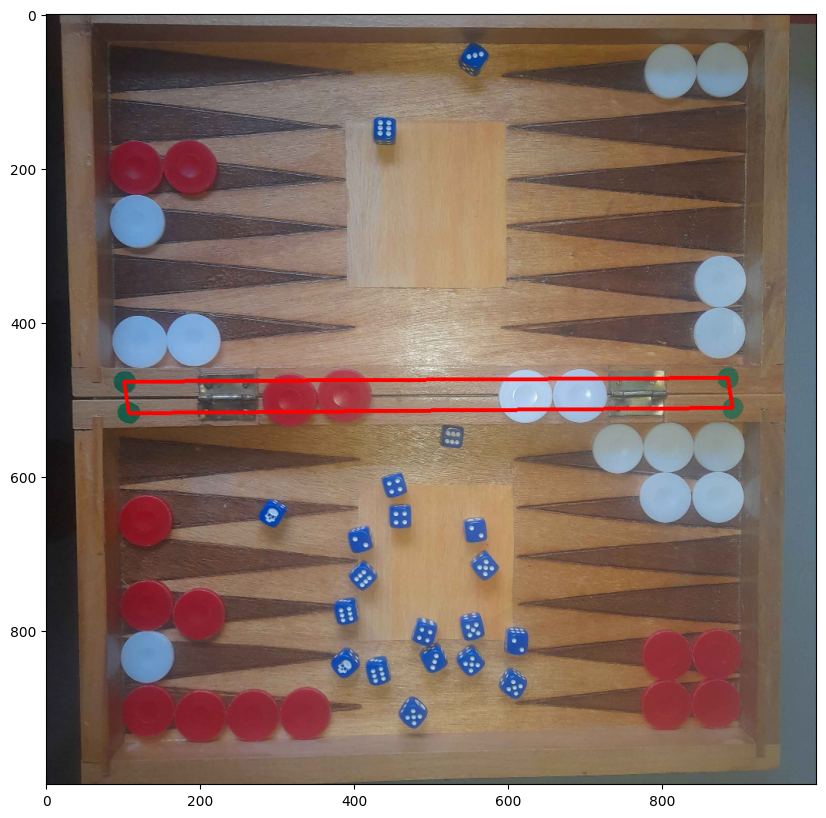

In [18]:
print(bar_indicators)

if len(bar_indicators) != 4: raise Exception("There need to be 4 indicators, not", len(bar_indicators)) #In the real code we will skip bar related activities

shortest_dist = 1000000
closest_indicator = None
# Create 2 pairs of points such that the distance between them is the smallest
for idx in [1,2,3]:
    dist = abs(bar_indicators[idx][0] - bar_indicators[0][0]) + abs(bar_indicators[idx][1] - bar_indicators[0][1]) #L1 distance
    if dist < shortest_dist:
        shortest_dist = dist
        closest_indicator = idx

pair1 = (0, closest_indicator)
pair2 = tuple([x for x in range(1,4) if x is not closest_indicator])
print(pair1, pair2)

x_positions = [x for (x,y) in bar_indicators]
y_positions = [y for (x,y) in bar_indicators]
print(x_positions)
print(y_positions)

img = cv2.resize(image, (1000,1000))
cv2.rectangle(img, (min(x_positions), min(y_positions)), (max(x_positions), max(y_positions)), (255, 0, 0), -1)
# Display the output
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()


img = cv2.resize(image, (1000,1000))
# Check if pair1[0] to pair2[0] intersects with pair1[1] to pair2[1] if yes, swap pair2 such that the lines do not intersect
if do_lines_intersect(bar_indicators[pair1[0]], bar_indicators[pair2[1]], bar_indicators[pair1[1]], bar_indicators[pair2[0]]):
    print("swapped")
    pair2 = (pair2[1], pair2[0])

# Draw lines between indicators in pairs
cv2.line(img, bar_indicators[pair1[0]], bar_indicators[pair1[1]], (255,0,0), 3) 
cv2.line(img, bar_indicators[pair2[0]], bar_indicators[pair2[1]], (255,0,0), 3)

# Draw lines between points from other pairs
cv2.line(img, bar_indicators[pair1[0]], bar_indicators[pair2[1]], (255,0,0), 3) 
cv2.line(img, bar_indicators[pair1[1]], bar_indicators[pair2[0]], (255,0,0), 3)

# Display the output
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()


In [19]:
shortest_dist

45

[(885, 472), (101, 477), (107, 518), (891, 511)]
[(903, 454), (83, 459), (89, 536), (909, 529)]


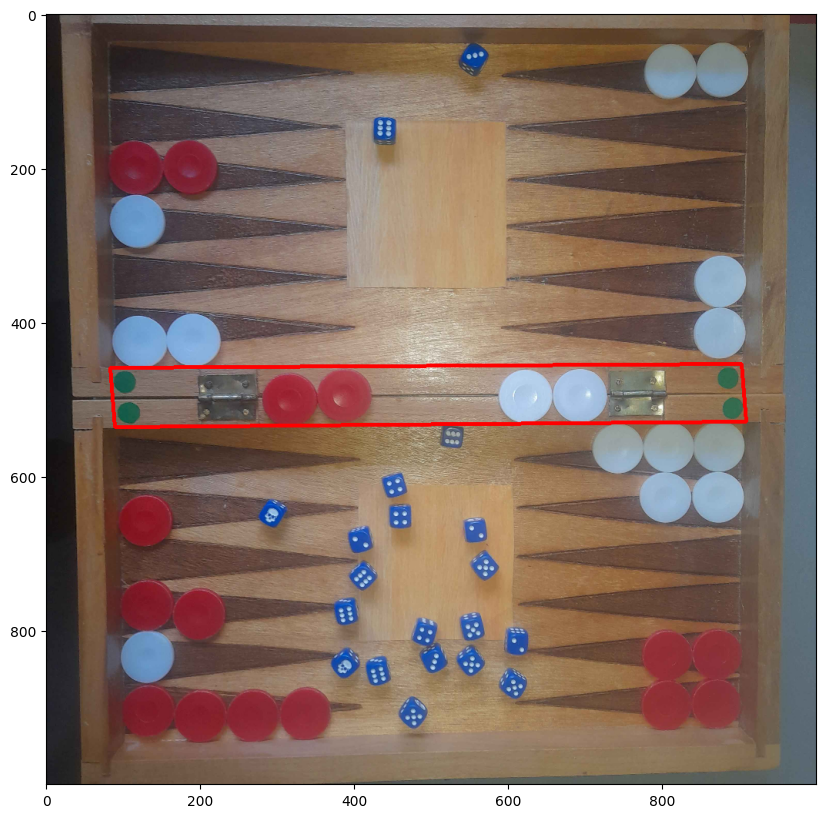

In [20]:
print(bar_indicators)

x_centre = np.mean(x_positions)
y_centre = np.mean(y_positions)

new_bar_indicators = []
for i in range(len(bar_indicators)):
    # Get points away from the ceter such that, 
    point = bar_indicators[i]

    new_point = [0,0]
    m = 0.4

    if point[0] > x_centre:
        new_point[0] = point[0] + int(m* shortest_dist)
    else:
        new_point[0] = point[0] - int(m* shortest_dist)

    if point[1] > y_centre:
        new_point[1] = point[1] + int(m* shortest_dist)
    else:
        new_point[1] = point[1] - int(m* shortest_dist)

    new_point = tuple(new_point)

    new_bar_indicators.append(new_point)

print(new_bar_indicators)

img = cv2.resize(image, (1000,1000))
cv2.line(img, new_bar_indicators[pair1[0]], new_bar_indicators[pair1[1]], (255,0,0), 3) 
cv2.line(img, new_bar_indicators[pair2[0]], new_bar_indicators[pair2[1]], (255,0,0), 3)

cv2.line(img, new_bar_indicators[pair1[0]], new_bar_indicators[pair2[1]], (255,0,0), 3) 
cv2.line(img, new_bar_indicators[pair1[1]], new_bar_indicators[pair2[0]], (255,0,0), 3)

# Display the output
plt.figure(figsize=(10,10))
plt.imshow(img), bar_indicators[pair1[1]], bar_indicators[pair2[0]]
plt.show()